## Multivariate Timeseries Graph Neural Network (MTGNN)
The MTGNN model is a combination of graph convolution (GC) and temporal convolution (TC) blocks combined with a graph structure learning layer.<br />

The graph construction layer assumes the information flow between nodes in the graph<br />
is strictly uni-directional and learns a skew-symmetric adjacency matrix, meaning that $ A = -A^T$. <br />
This matrix $A$ is then put through a ReLU function to remove the negative weights.

The model structure looks like:<br /><br />
<pre>
    &#8625; res_channels &#10141;                 &#8628; <br />
... &#10141;    TC   &#10141;     GC|A   &#10141; GC_out + res_channels &#10141; ... &#10141; last_layer_out <br />
... &#10141;         &#8627; TC_out + skip channels &#10141;            &#10565; ... &#10565;     &#8627; last_layer_out + skip_channels  <br />
                                                                                   &#8681; <br />
                                                                              end_channels  
                                                                                   &#8681; <br />
                                                                              out_channels <br />
<br /></pre>
The skip connections are summed up after every temporal convolution and carried until the end of the model and used to compute the final output. <br />
Residual connections go from the input of a TC/GC block to the output. <br />

### MTGNN

100%|██████████| 200/200 [06:53<00:00,  2.07s/it]


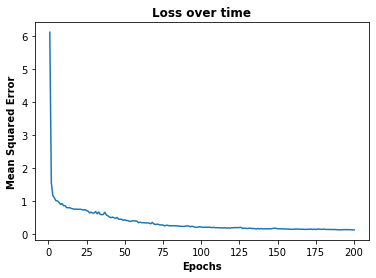

Train MSE: 0.1186
Test MSE: 0.7675


In [13]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch_geometric_temporal.nn.attention import MTGNN
from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

from torch_geometric.data import DataLoader

loader = ChickenpoxDatasetLoader()

lags = 10
stride = 1
epochs = 200
batch_size = 32

dataset = loader.get_dataset(lags)

sample = next(iter(dataset))
num_nodes = sample.x.size(0)

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.4)

train_loader = DataLoader(list(train_dataset), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(list(test_dataset), batch_size=batch_size, shuffle=False)

### MODEL DEFINITION
class AttentionGCN(nn.Module):
    def __init__(self):
        super(AttentionGCN, self).__init__()

        self.attention = MTGNN(
            gcn_true=True,
            build_adj=True,
            gcn_depth=2,
            num_nodes=num_nodes,
            kernel_set=[5,5,5],
            kernel_size=5,
            dropout=0.2,
            subgraph_size=num_nodes,
            node_dim=1,
            dilation_exponential=3,
            conv_channels=9,
            residual_channels=16,
            skip_channels=16,
            end_channels=32,
            seq_length=lags,
            in_dim=1,
            out_dim=1,
            layers=3,
            propalpha=0.4,
            tanhalpha=1,
            layer_norm_affline=True,
            xd=None
        )

    def forward(self, window):     
        x = window.x.view(-1, 1, num_nodes, lags) # (batch, 1, lags, num_nodes)      
        x = self.attention(x) # (batch, lags, num_nodes, 1)
        return x.squeeze(-1).permute(0,2,1).flatten()
    
model = AttentionGCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

### TRAIN
model.train()

loss_history = []
for _ in tqdm(range(epochs)):
    total_loss = 0
    for i, window in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = model(window)
        
        assert y_pred.shape == window.y.shape
        loss = torch.mean((y_pred - window.y)**2)
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    total_loss /= i+1
    loss_history.append(total_loss)

### TEST 
model.eval()
loss = 0
with torch.no_grad():
    for i, window in enumerate(test_loader):
        y_pred = model(window)
        
        assert y_pred.shape == window.y.shape
        loss += torch.mean((y_pred - window.y)**2)
    loss /= i+1

### RESULTS PLOT
fig, ax = plt.subplots()

x_ticks = np.arange(1, epochs+1)
ax.plot(x_ticks, loss_history)

# figure labels
ax.set_title('Loss over time', fontweight='bold')
ax.set_xlabel('Epochs', fontweight='bold')
ax.set_ylabel('Mean Squared Error', fontweight='bold')
plt.show()

print("Train MSE: {:.4f}".format(total_loss))
print("Test MSE: {:.4f}".format(loss))
